In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle
import seaborn as sns

## Configuration

### Plotting styling

In [4]:
colors = {}
#Expert algos
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'

#QKerasEMD with elink specific cms training
colors['AutoEncoderEMDPAIRMSE'] = 'tab:orange'
colors['AutoEncoderEMDAEMSLE'] = 'tab:purple'

#22 QKERAS
colors['AutoEncoderEMDPAIRMSE22'] = 'tab:red'
colors['AutoEncoderEMDAEMSE22'] = 'tab:green'
colors['AutoEncoderTelescopeMSE22'] = 'tab:blue'
colors['AutoEncoderEMDAEMSLE22'] = 'tab:pink'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'

styles['AutoEncoderEMDAEMSLE'] = '--'
styles['AutoEncoderEMDPAIRMSE'] = '--'

styles['AutoEncoderEMDPAIRMSE22'] = '--'
styles['AutoEncoderEMDAEMSE22'] = '--'
styles['AutoEncoderTelescopeMSE22'] = '-'
styles['AutoEncoderEMDAEMSLE22'] = '--'

markers = {}
markers['Threshold0'] =  'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'

markers['AutoEncoderEMDAEMSLE'] = 'o'
markers['AutoEncoderEMDPAIRMSE'] = 'o'

markers['AutoEncoderEMDPAIRMSE22'] = 'o'
markers['AutoEncoderEMDAEMSE22'] = 'o'
markers['AutoEncoderTelescopeMSE22'] = 'o'
markers['AutoEncoderEMDAEMSLE22'] = 'o'


legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'

legends['AutoEncoderEMDPAIRMSE'] = 'elink: QAE w/ Loss: Pair MSE'
legends['AutoEncoderEMDAEMSLE'] = 'elink: QAE w/ Loss: AE MSLE'

legends['AutoEncoderEMDPAIRMSE22'] = 'QAE w/ Loss: Pair MSE'
legends['AutoEncoderEMDAEMSE22'] = 'QAE w/ Loss: AE MSE'
legends['AutoEncoderTelescopeMSE22'] = 'QAE w/ Loss: Tele'
legends['AutoEncoderEMDAEMSLE22'] = 'QAE w/ Loss: AE MSLE'

ref_name = 'Threshold0'

"""
Keys
1: 10_18_1 ['AutoEncoderStrideAEMSE', 'AutoEncoderStrideAppMSE', 'AutoEncoderStridePairHuber', 'AutoEncoderStridePairMSE', ]>
2: 11_8_1  ['AutoEncoderStrideAEHuber', 'AutoEncoderStrideAEMSLE', 'AutoEncoderStrideAPPHuber', 'AutoEncoderStrideAPPMSLE', ]
3: 11_22_1(QKERAS) = ['Threshold','Threshold0','Mixedbcstc','AutoEncoderTelescopeMSE','AutoEncoderEMDAEMSE','AutoEncoderEMDPAIRHUBER']
4: 12_04_21(QKERAS) = ['AutoEncoderEMDAEMSLE','AutoEncoderEMDAEHuber','AutoEncoderEMDPAIRMSE']
5: 12_18_21(QKERAS+ELINK SPECIFIC TRAINING): 'AutoEncoderEMDAEMSLE','AutoEncoderEMDPAIRMSE']
6: 01_26_22(QKERAS): 'AutoEncoderEMDAEMSLE22','AutoEncoderEMDAEMSE22,''AutoEncoderTelescopeMSE22','AutoEncoderEMDPAIRMSE22']
"""

"\nKeys\n1: 10_18_1 ['AutoEncoderStrideAEMSE', 'AutoEncoderStrideAppMSE', 'AutoEncoderStridePairHuber', 'AutoEncoderStridePairMSE', ]>\n2: 11_8_1  ['AutoEncoderStrideAEHuber', 'AutoEncoderStrideAEMSLE', 'AutoEncoderStrideAPPHuber', 'AutoEncoderStrideAPPMSLE', ]\n3: 11_22_1(QKERAS) = ['Threshold','Threshold0','Mixedbcstc','AutoEncoderTelescopeMSE','AutoEncoderEMDAEMSE','AutoEncoderEMDPAIRHUBER']\n4: 12_04_21(QKERAS) = ['AutoEncoderEMDAEMSLE','AutoEncoderEMDAEHuber','AutoEncoderEMDPAIRMSE']\n5: 12_18_21(QKERAS+ELINK SPECIFIC TRAINING): 'AutoEncoderEMDAEMSLE','AutoEncoderEMDPAIRMSE']\n6: 01_26_22(QKERAS): 'AutoEncoderEMDAEMSLE22','AutoEncoderEMDAEMSE22,''AutoEncoderTelescopeMSE22','AutoEncoderEMDPAIRMSE22']\n"

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [5]:
version = '01_30_22'
fig_dir = 'img/electron_photon_calib_autoencoder_{}'.format(version)
algo_files = {}
# Read  first set
directory1 = '/home/cms.rshenoy/10_18_1/electron_photon_signaldriven/v_1_2021-10-23'
directory2 = '/home/cms.rshenoy/11_8_1/electron_photon_signaldriven/v_1_2021-11-08'
directory3 = '/home/cms.rshenoy/11_22_1/electron_photon_signaldriven/v_1_2021-12-01'
directory4 = '/home/cms.rshenoy/12_04_21/electron_photon_signaldriven/v_1_2021-12-05'
directory5 = '/home/cms.rshenoy/12_18_21/electron_photon_signaldriven/v_1_2021-12-18'
directory6 = '/home/cms.rshenoy/01_26_22/electron_photon_signaldriven/v_1_2022-01-27'

fes =['Threshold0',
      'Threshold',
      'Mixedbcstc',
      'AutoEncoderEMDAEMSLE',
      'AutoEncoderEMDPAIRMSE',
      'AutoEncoderEMDAEMSLE22',
      'AutoEncoderEMDAEMSE22',
      'AutoEncoderTelescopeMSE22',
      'AutoEncoderEMDPAIRMSE22']


In [6]:
for fe in fes:
    if(fe=='AutoEncoderEMDAEMSLE22' or fe=='AutoEncoderEMDAEMSLE22'or fe=='AutoEncoderTelescopeMSE22'or fe=='AutoEncoderEMDPAIRMSE22'):
        algo_files[fe] = (glob(directory6+'/electrons/*.hdf5'), glob(directory6+'/photons/*.hdf5'))
    elif(fe=='AutoEncoderEMDAEMSLE'or fe=='AutoEncoderEMDPAIRMSE'):
        algo_files[fe] = (glob(directory5+'/electrons/*.hdf5'), glob(directory5+'/photons/*.hdf5'))
    else:
        algo_files[fe] = (glob(directory6+'/electrons/*.hdf5'), glob(directory6+'/photons/*.hdf5'))
        #expert algos

## Loading and preprocessing dataframes

In [7]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [8]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [9]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [10]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

Threshold0
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.5748e+05, final cost 6.8491e+04, first-order optimality 7.82e-09.
[2.         0.78481414 1.18365569 0.92988944 1.03620326 1.10678243
 0.97273912 1.1451926  0.99622551 0.62170175 1.05548903 2.
 2.        ]
Threshold
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.4195e+05, final cost 7.1733e+04, first-order optimality 6.88e-09.
[1.98674042 0.84871352 1.18466537 0.94066086 1.04534741 1.1187266
 0.9608574  1.17176152 1.01398139 0.62805343 1.0197385  2.
 2.        ]
Mixedbcstc
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.5350e+05, final cost 8.0508e+04, first-order optimality 8.87e-10.
[1.99855585 0.77921598 1.26571567 0.90184872 1.03150641 1.48773877
 0.90480224 1.25723926 1.1686662  0.92272128 1.25012085 2.
 2.        ]
AutoEncoderEMDAEMSLE
The relative change of the cost f

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [11]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

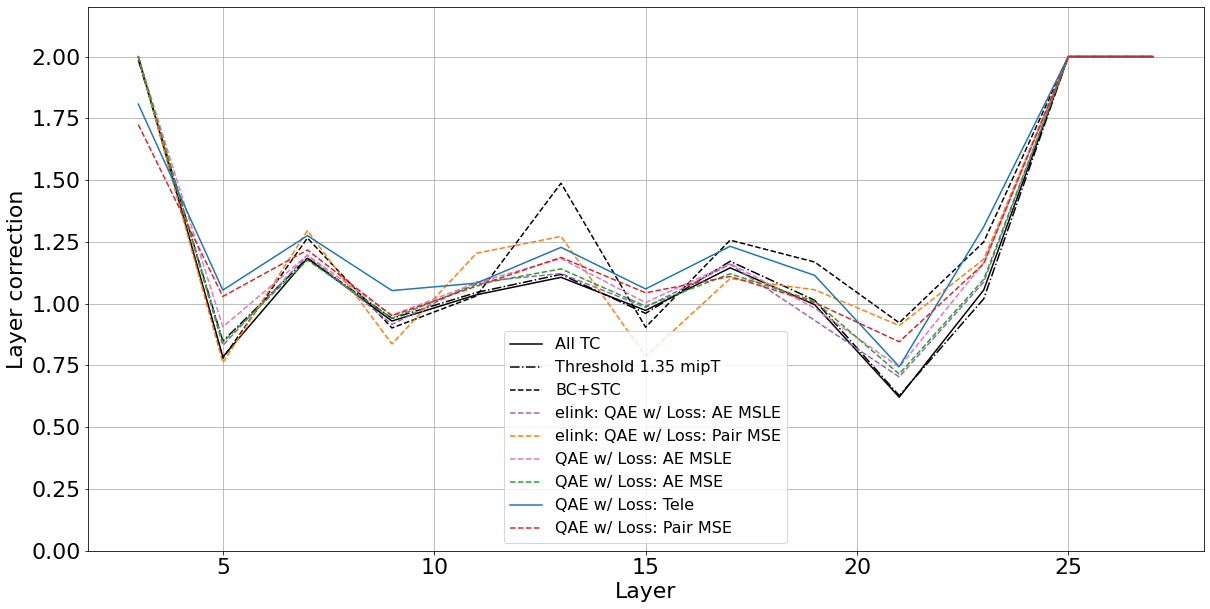

In [12]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.savefig('/home/cms.rshenoy/Plots/layer_corrections.png')
plt.show()


Check impact of layer corrections on the energy ratio distributions

Raw mean=0.9606194496154785, rms=0.032879360020160675, rms/mean=0.03422724828124046
Calib mean=0.9987665771643545, rms=0.04018569572478504, rms/mean=0.04023532289083817


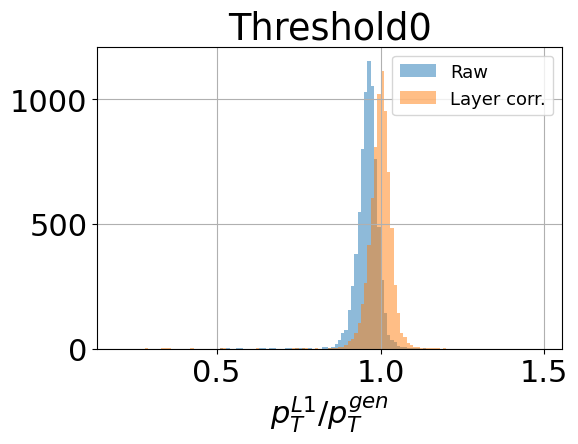

Raw mean=0.940360426902771, rms=0.039580028504133224, rms/mean=0.0420902743935585
Calib mean=0.9873233859474514, rms=0.04566307350791505, rms/mean=0.04624935877933858


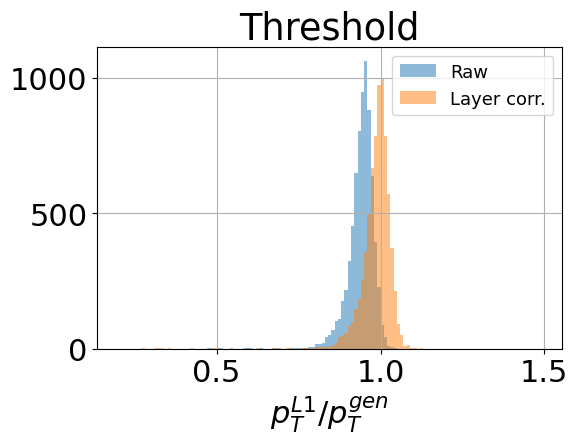

Raw mean=0.8866852521896362, rms=0.03558803349733353, rms/mean=0.04013603925704956
Calib mean=1.0017000420210485, rms=0.04321261663975415, rms/mean=0.04313927805430414


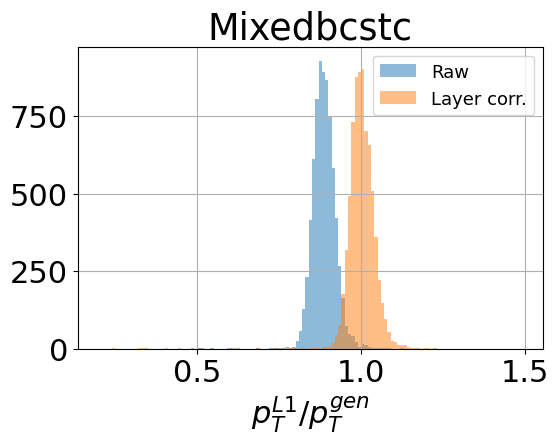

Raw mean=0.9436830282211304, rms=0.033550262451171875, rms/mean=0.03555246815085411
Calib mean=0.9961022228806333, rms=0.04102841009961914, rms/mean=0.04118895546781219


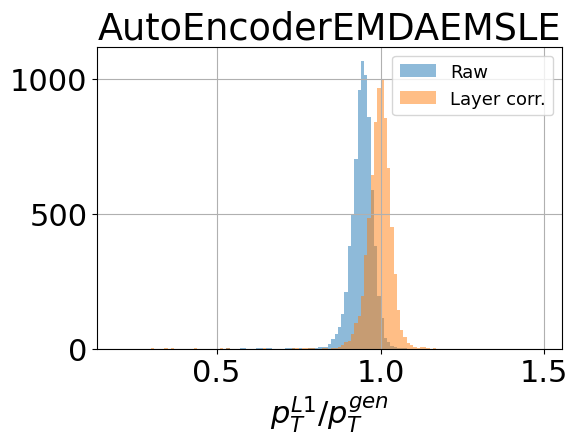

Raw mean=0.919161856174469, rms=0.0419125035405159, rms/mean=0.04559861123561859
Calib mean=0.9949481167018199, rms=0.04967140541731951, rms/mean=0.049923613687492145


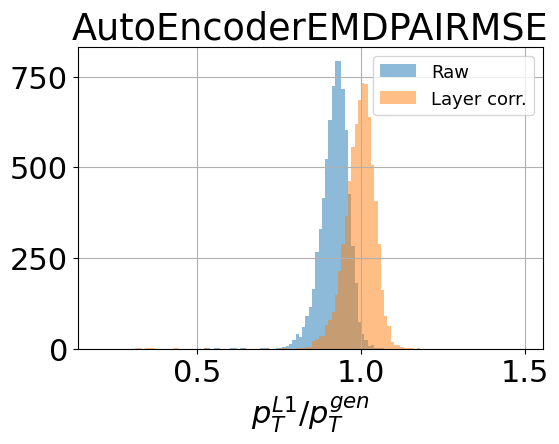

Raw mean=0.9201701879501343, rms=0.03514513000845909, rms/mean=0.038194164633750916
Calib mean=0.9960127004361554, rms=0.04328835529280148, rms/mean=0.043461649910533716


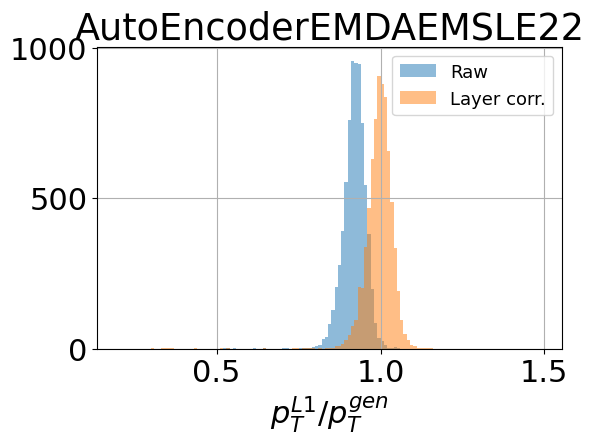

Raw mean=0.9377373456954956, rms=0.03408946841955185, rms/mean=0.03635289520025253
Calib mean=0.9957698791110925, rms=0.041617254727677, rms/mean=0.041794048605716054


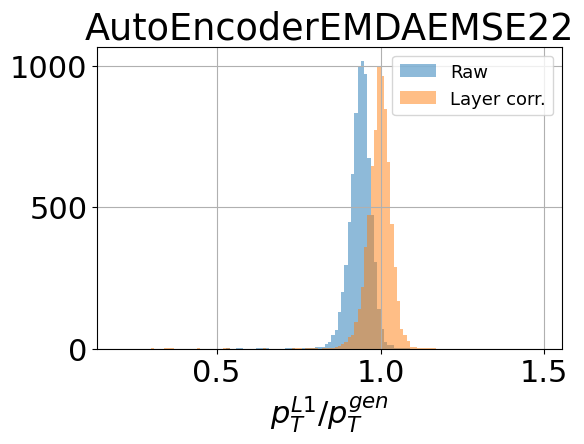

Raw mean=0.8727798461914062, rms=0.038448017090559006, rms/mean=0.0440523661673069
Calib mean=0.9966446135639881, rms=0.04852349021216796, rms/mean=0.048686853419744665


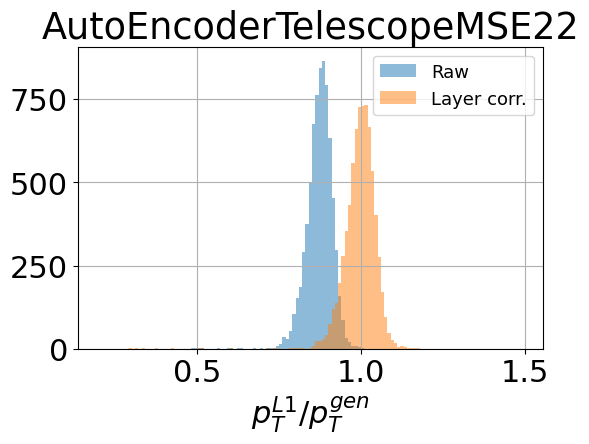

Raw mean=0.9123849868774414, rms=0.04263487830758095, rms/mean=0.04672904312610626
Calib mean=0.9954964574317003, rms=0.05075573606769787, rms/mean=0.05098535076522877


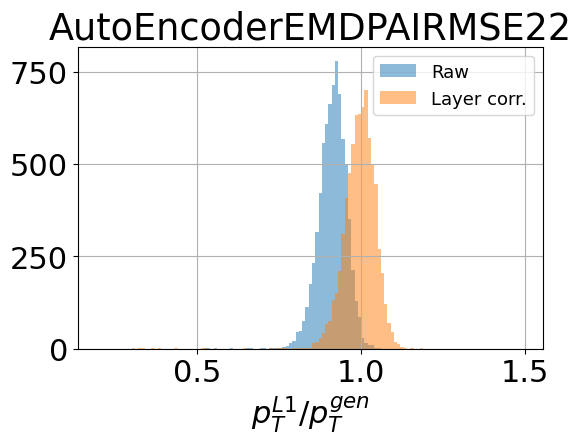

In [13]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.savefig('/home/cms.rshenoy/Plots/energy_ratio_'+name+'.png')
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [14]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  Threshold0
  Threshold
  Mixedbcstc
  AutoEncoderEMDAEMSLE
  AutoEncoderEMDPAIRMSE
  AutoEncoderEMDAEMSLE22
  AutoEncoderEMDAEMSE22
  AutoEncoderTelescopeMSE22
  AutoEncoderEMDPAIRMSE22


Print correction value at eta=1.5 and eta=3

In [15]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

Threshold0
  eta=1.5: [3.7760773]
  eta=3: [-9.681198]
Threshold
  eta=1.5: [3.5413485]
  eta=3: [-9.2776165]
Mixedbcstc
  eta=1.5: [4.5927677]
  eta=3: [-3.6228247]
AutoEncoderEMDAEMSLE
  eta=1.5: [4.0282326]
  eta=3: [-17.943636]
AutoEncoderEMDPAIRMSE
  eta=1.5: [4.388363]
  eta=3: [-17.062252]
AutoEncoderEMDAEMSLE22
  eta=1.5: [3.82621]
  eta=3: [-17.629644]
AutoEncoderEMDAEMSE22
  eta=1.5: [3.955824]
  eta=3: [-17.767378]
AutoEncoderTelescopeMSE22
  eta=1.5: [4.4119167]
  eta=3: [-17.018402]
AutoEncoderEMDPAIRMSE22
  eta=1.5: [3.9016743]
  eta=3: [-16.69818]


In [16]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt'] 

Raw mean=0.9974378347396851, rms=0.12009961158037186, rms/mean=0.12040811777114868
Calib mean=1.0409089294298408, rms=0.1080230454133493, rms/mean=0.1037776143130207
Corr eta mean=0.9960538340875401, rms=0.06730845859168495, rms/mean=0.06757512123161952


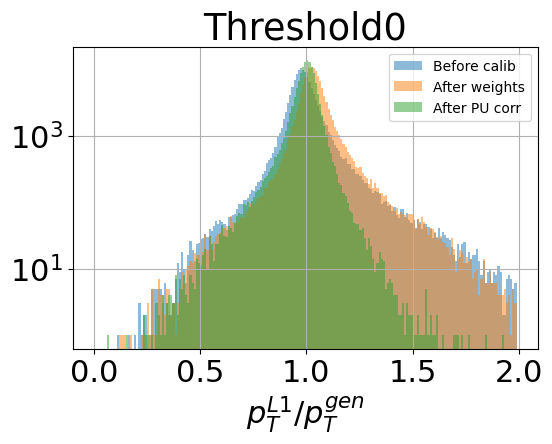

Raw mean=0.9691261649131775, rms=0.09808096289634705, rms/mean=0.10120556503534317
Calib mean=1.0320519037162454, rms=0.09871360591938193, rms/mean=0.0956479083696574
Corr eta mean=0.9884428403860178, rms=0.07357957152518704, rms/mean=0.07443988515962331


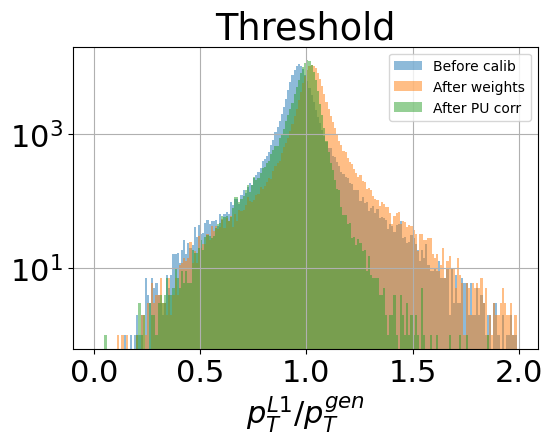

Raw mean=0.8990583419799805, rms=0.08573984354734421, rms/mean=0.09536627680063248
Calib mean=0.9928617346071431, rms=0.07896002907768686, rms/mean=0.07952771904229936
Corr eta mean=1.0015615748015732, rms=0.06740709084084735, rms/mean=0.06730199374332214


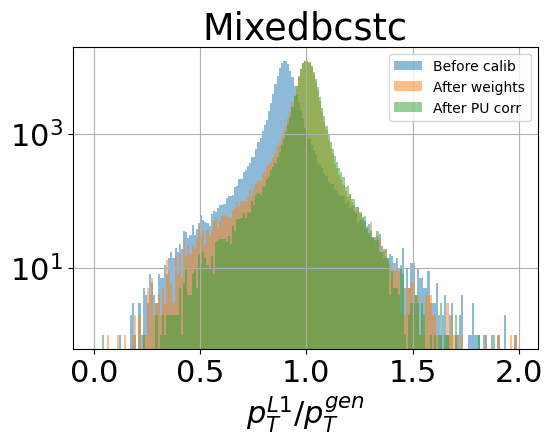

Raw mean=1.0239025354385376, rms=0.1453378051519394, rms/mean=0.14194495975971222
Calib mean=1.089844169109122, rms=0.14025841837837968, rms/mean=0.12869584694207428
Corr eta mean=0.9822313944148037, rms=0.09189759312836941, rms/mean=0.09356002429867394


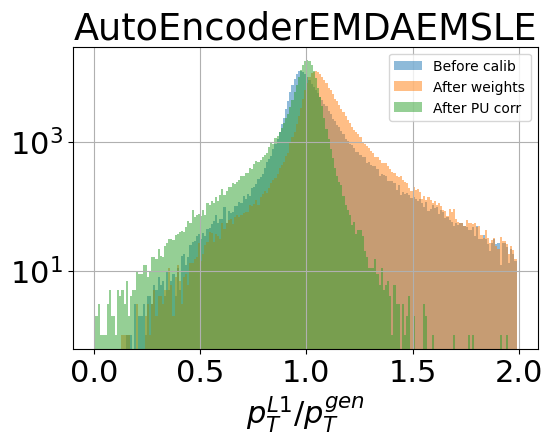

Raw mean=0.9977108836174011, rms=0.1419050544500351, rms/mean=0.14223062992095947
Calib mean=1.0823974848733353, rms=0.13835535054717343, rms/mean=0.12782305251140166
Corr eta mean=0.9844570053944005, rms=0.08901221812889952, rms/mean=0.09041757805688912


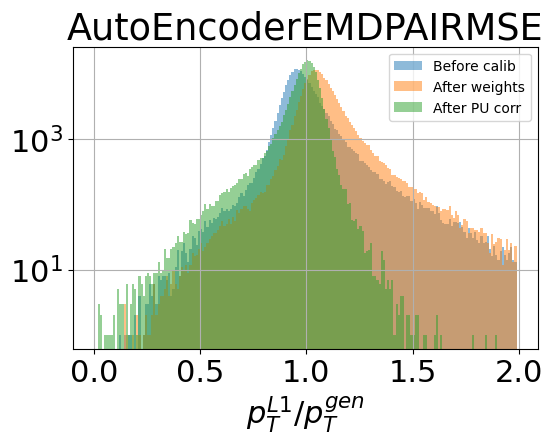

Raw mean=0.9979003667831421, rms=0.13936637341976166, rms/mean=0.13965961337089539
Calib mean=1.088345077922898, rms=0.1373037212227982, rms/mean=0.1261582599195852
Corr eta mean=0.9821984381626081, rms=0.09035621688784747, rms/mean=0.09199385111716958


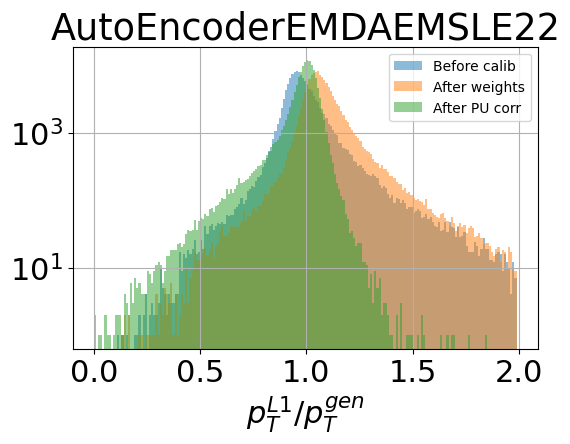

Raw mean=1.0181795358657837, rms=0.14214202761650085, rms/mean=0.1396040916442871
Calib mean=1.0884370917225414, rms=0.1375188855149511, rms/mean=0.12634527669147705
Corr eta mean=0.9823034070511867, rms=0.09112840056843366, rms/mean=0.09277011554097671


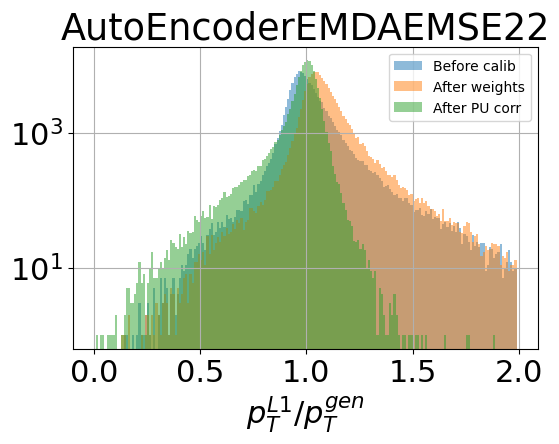

Raw mean=0.9424119591712952, rms=0.13505738973617554, rms/mean=0.14331035315990448
Calib mean=1.0808618179053497, rms=0.13770930182894703, rms/mean=0.12740694466922703
Corr eta mean=0.9843373208224412, rms=0.0919310530628971, rms/mean=0.09339385098808013


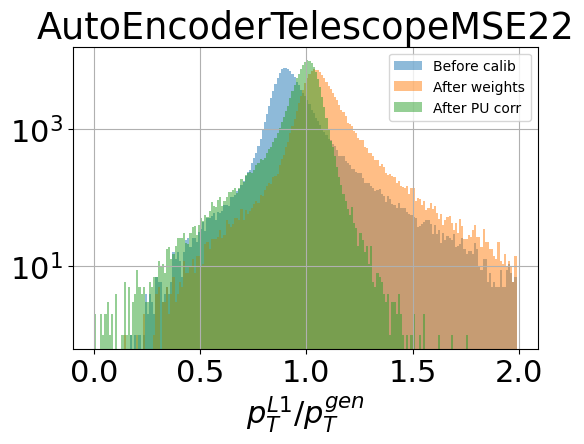

Raw mean=0.987809419631958, rms=0.13973979651927948, rms/mean=0.14146432280540466
Calib mean=1.082279961343159, rms=0.13723302040871, rms/mean=0.12679992729274736
Corr eta mean=0.9839743434874495, rms=0.09093344156822673, rms/mean=0.09241444369975749


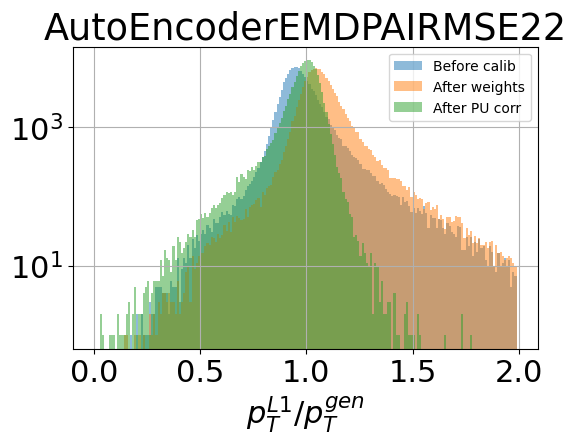

In [17]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.savefig('/home/cms.rshenoy/Plots/eta_corrections'+name+'.png')
    plt.show()

## Final plots
For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [18]:
binetasize = 0.1
binptsize = 5
for name,df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = ((df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [19]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(np.subtract(x[m:],x[:-m])) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [20]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {}
both_means={}
both_eff_rms={}
both_full_rms={}
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']


for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    both_means[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).mean()
    both_eff_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).apply(effrms)
    both_full_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).std()
    #print(etarmss[name])

In [21]:
plotted_algo = ['Threshold0',
      'Threshold',
      'Mixedbcstc',
      'AutoEncoderEMDAEMSLE',
      'AutoEncoderEMDPAIRMSE',
      'AutoEncoderEMDAEMSLE22',
      'AutoEncoderEMDAEMSE22',
      'AutoEncoderTelescopeMSE22',
      'AutoEncoderEMDPAIRMSE22']

Mean vs eta


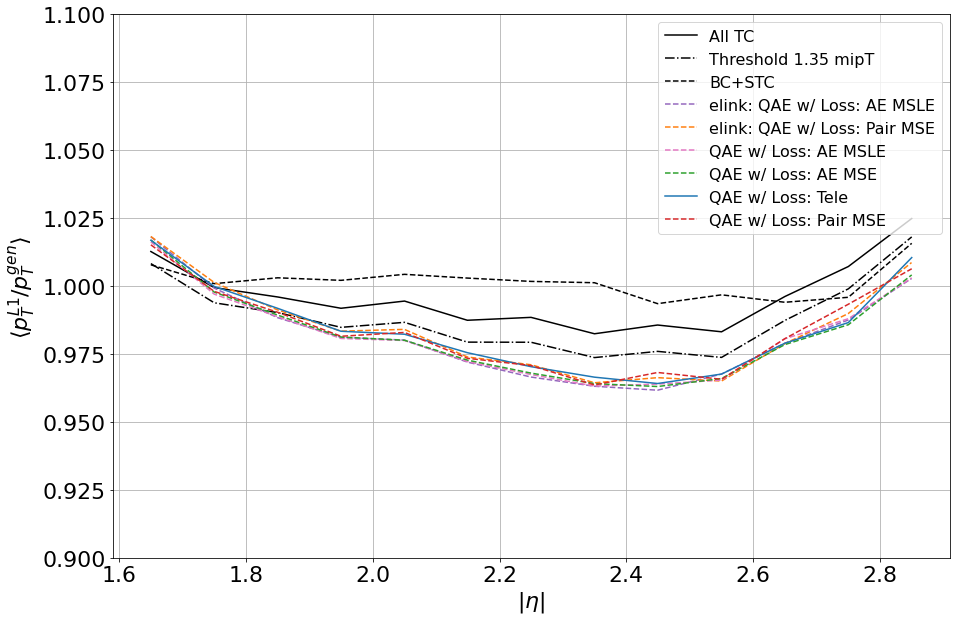

RMS vs eta


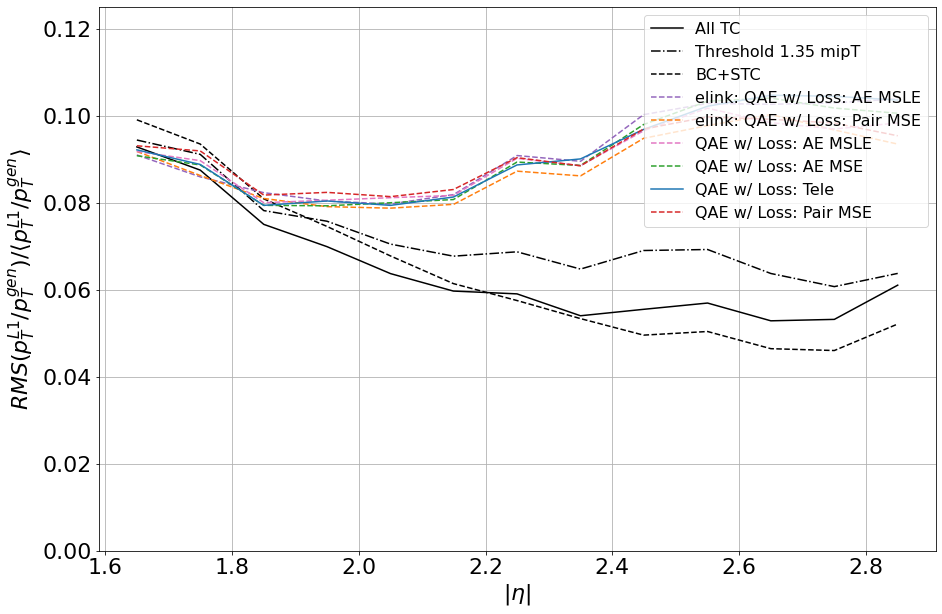

Eff RMS vs eta


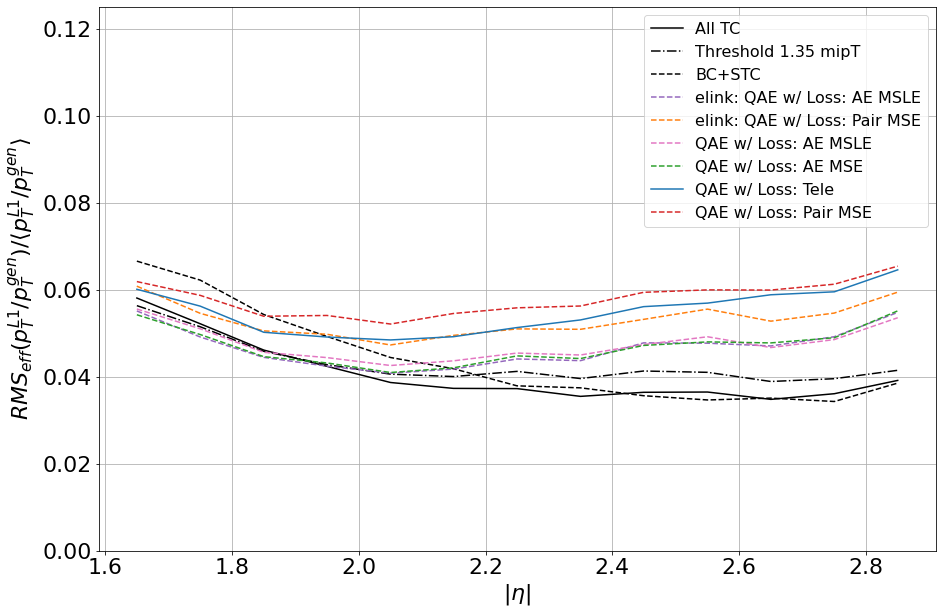

Mean vs pt


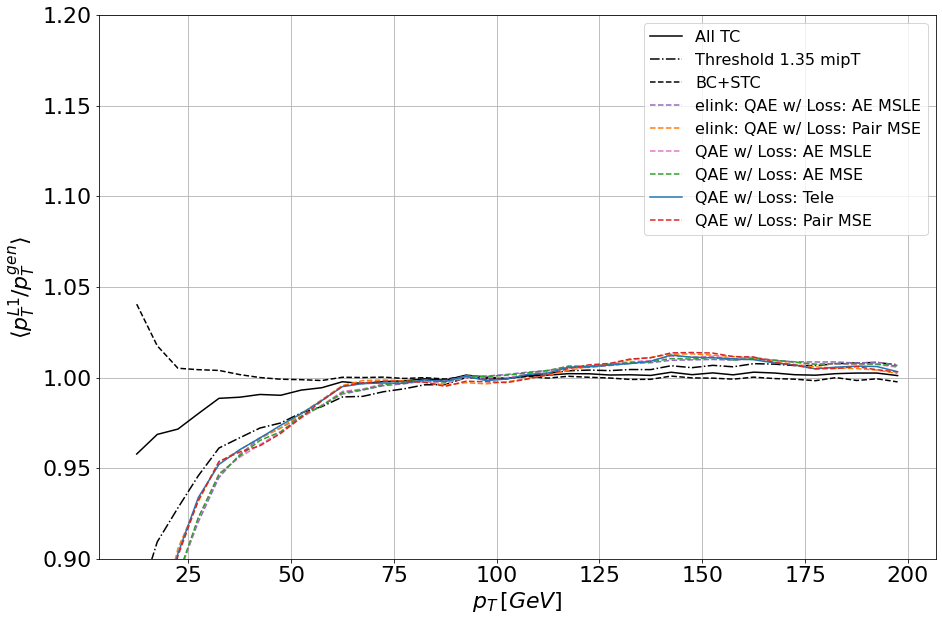

RMS vs pt


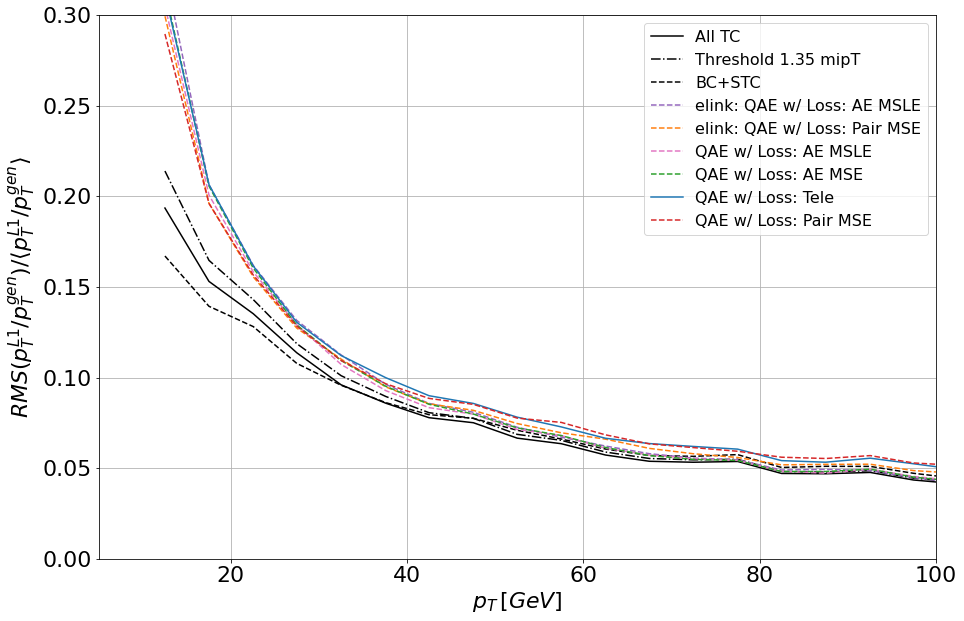

Eff RMS vs pt


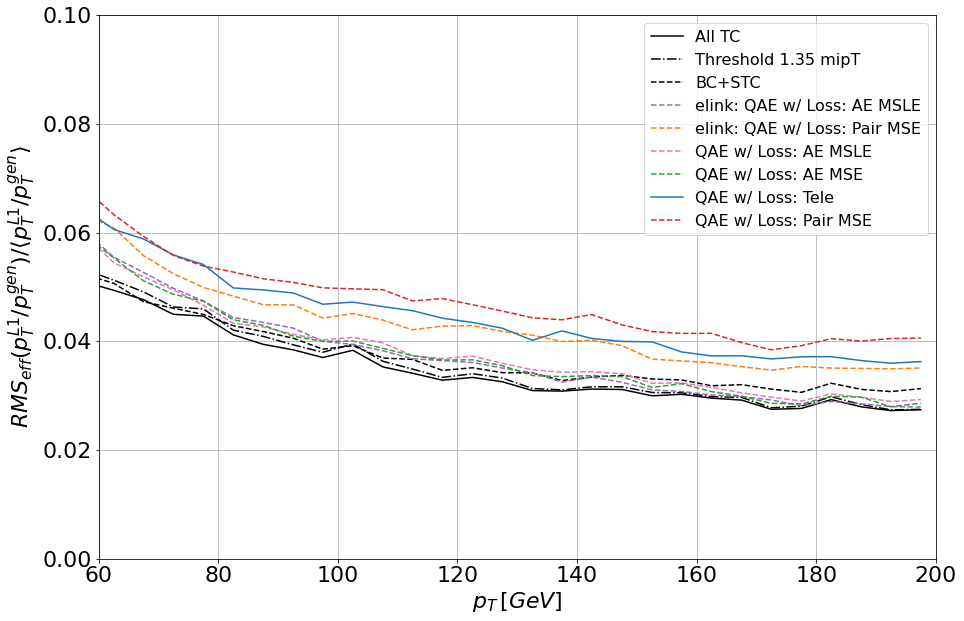

In [22]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig('/home/cms.rshenoy/Plots/mean_v_eta.png')
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.125)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig('/home/cms.rshenoy/Plots/rms_v_eta.png')
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.125)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig('/home/cms.rshenoy/Plots/rms_eff_v_eta.png')
plt.show()
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig('/home/cms.rshenoy/Plots/mean_v_pT.png')
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig('/home/cms.rshenoy/Plots/rms_v_pT.png')
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.1)
plt.xlim(60,200)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig('/home/cms.rshenoy/Plots/rms_eff_v_pT.png')
plt.show()

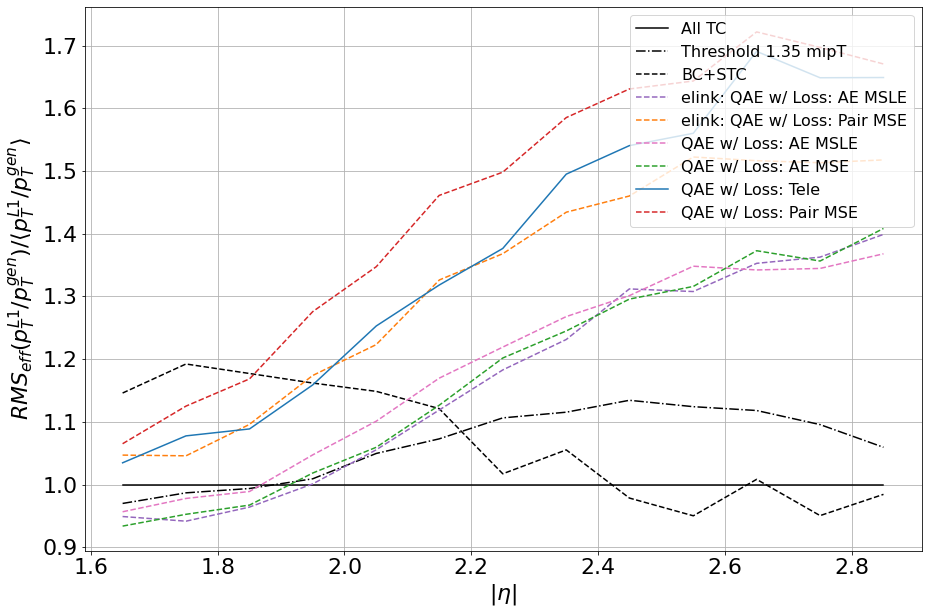

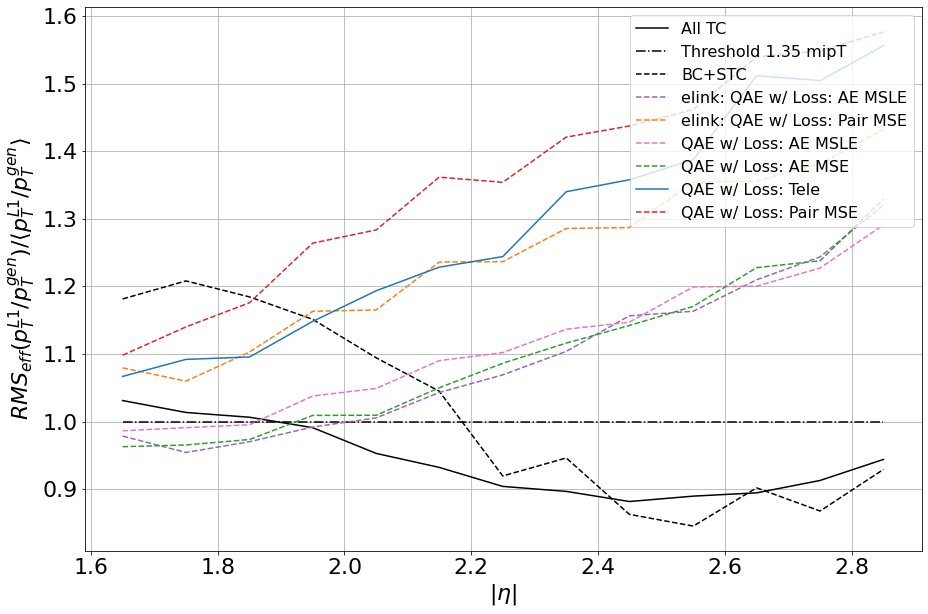

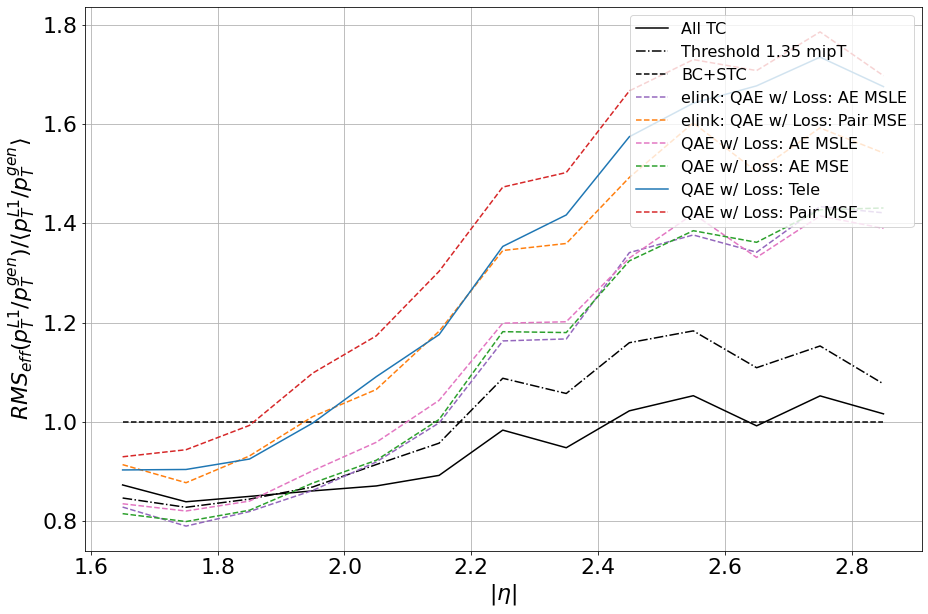

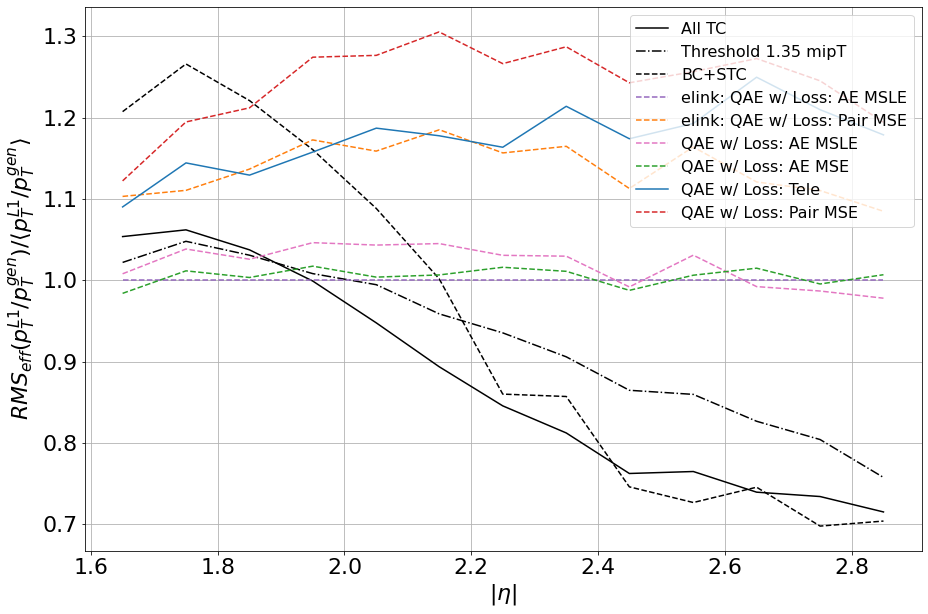

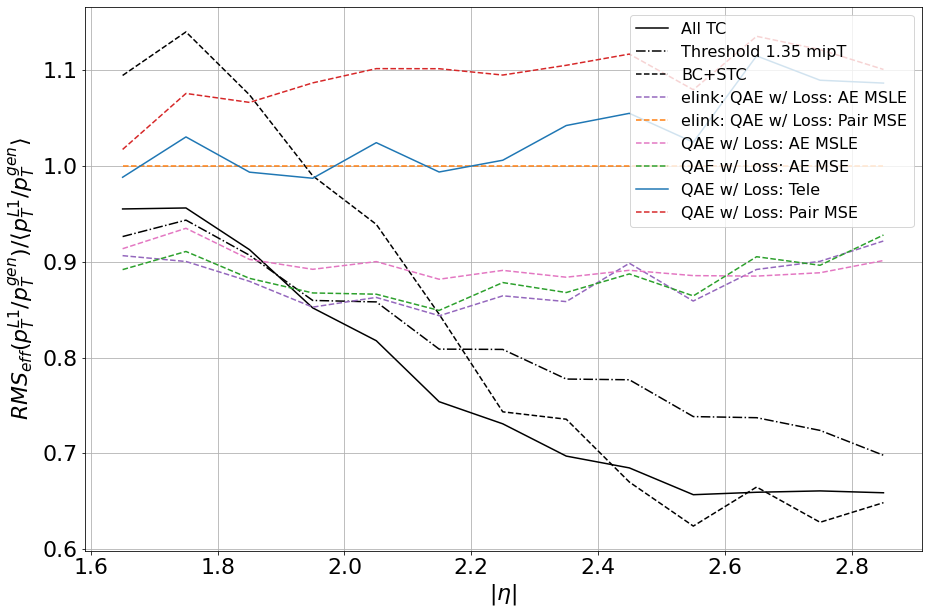

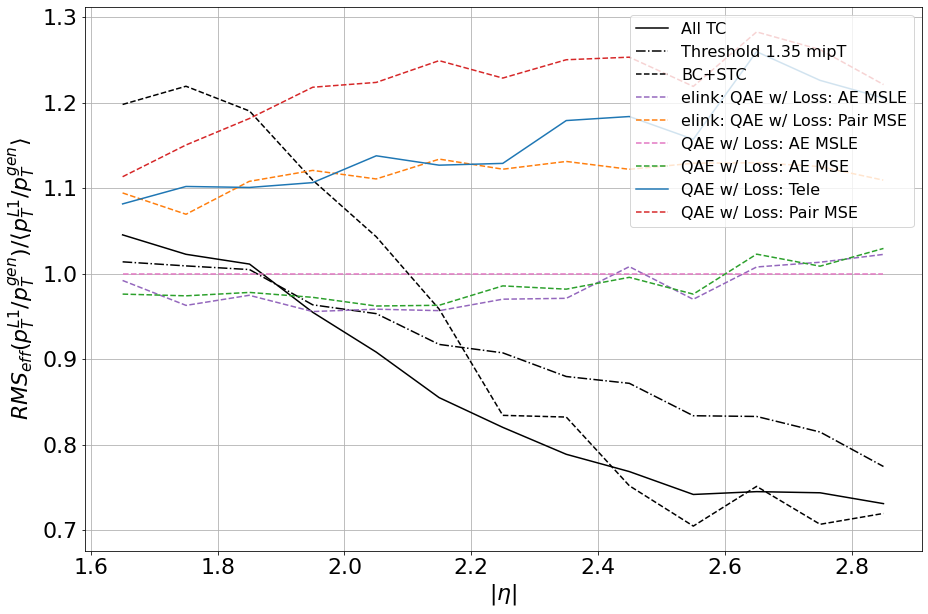

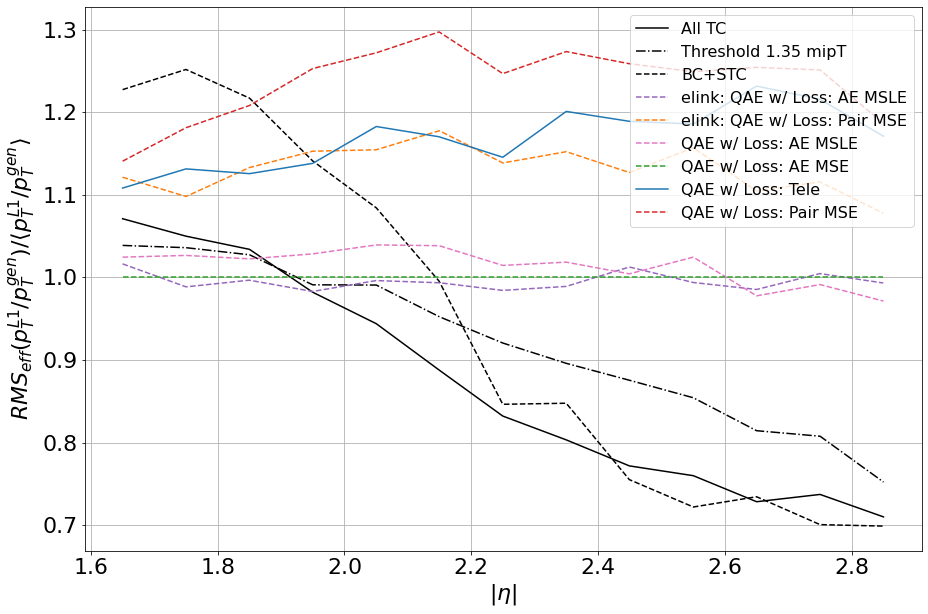

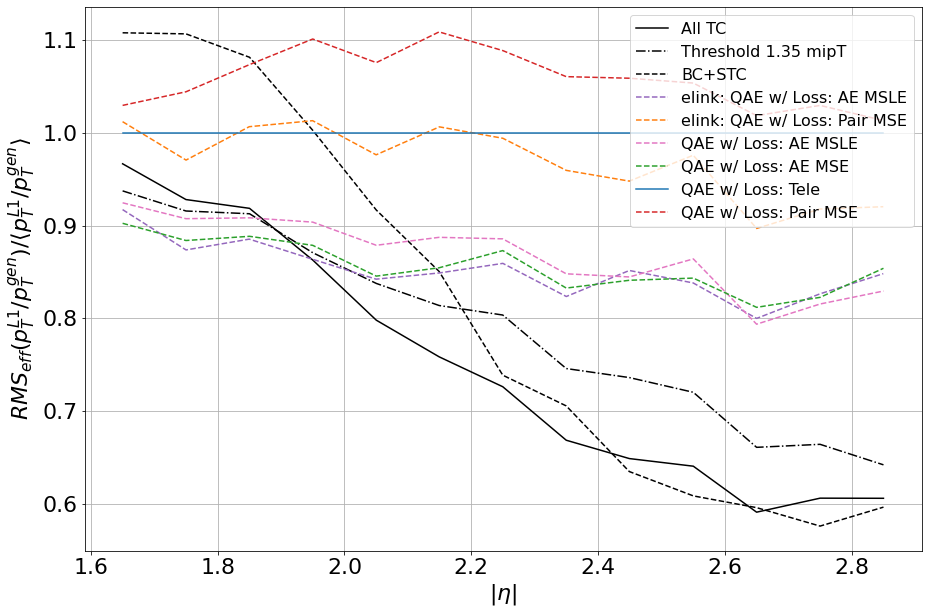

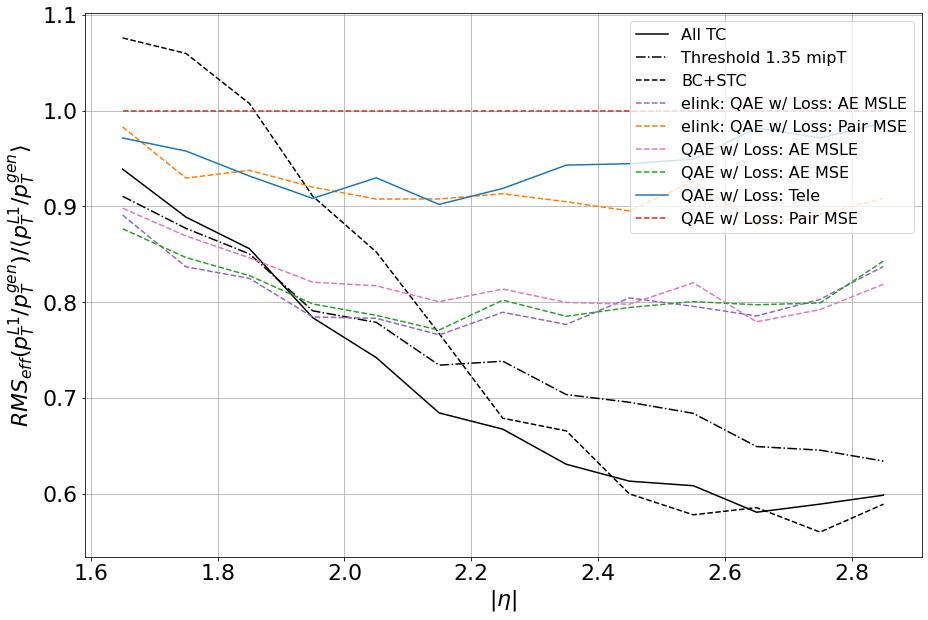

In [23]:
#Ratio effective RMS vs eta

Ratio_Against = ['Threshold0',
      'Threshold',
      'Mixedbcstc',
      'AutoEncoderEMDAEMSLE',
      'AutoEncoderEMDPAIRMSE',
      'AutoEncoderEMDAEMSLE22',
      'AutoEncoderEMDAEMSE22',
      'AutoEncoderTelescopeMSE22',
      'AutoEncoderEMDPAIRMSE22']

for ratio_against in Ratio_Against:
    df_denom=df = etameans[ratio_against]
    denom=(etaeffrmss[ratio_against]['corr_eta_over_gen_pt']/df_denom['corr_eta_over_gen_pt'])
    plt.figure(figsize=(15,10))
    for name in plotted_algo:
        df = etameans[name]
        ratio_eff_rms = (etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'])/denom
        plt.plot(df['genpart_abseta'],ratio_eff_rms,  color=colors[name], ls=styles[name], label=legends[name])
    
    plt.legend(loc = 'upper right', fontsize=16)
    plt.xlabel(r'$|\eta|$')
    plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
    plt.grid()
    plt.savefig('/home/cms.rshenoy/Plots/ratio_'+ratio_against+'rms_eff_v_eta.png')
    plt.show()
    
    

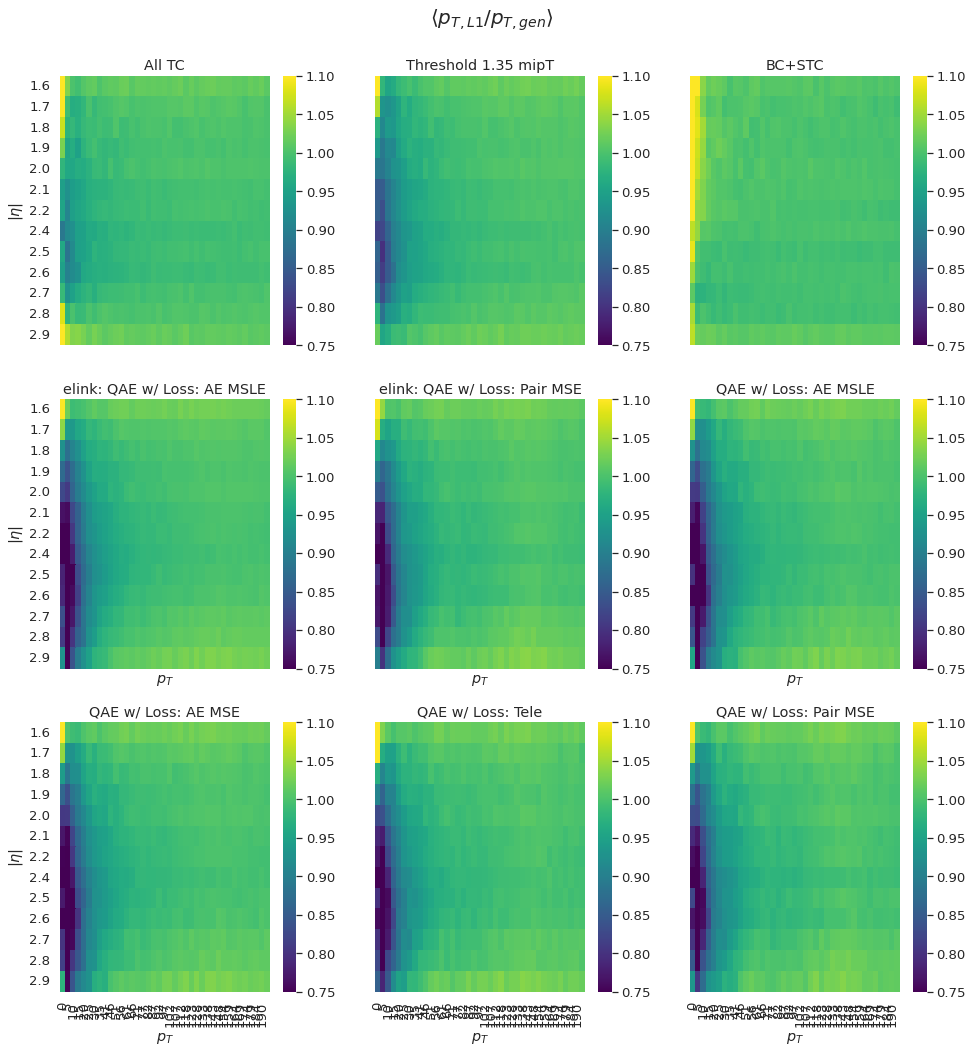

In [24]:
#Mean heatmaps
sns.set(font_scale=1.2)
fig, axes = plt.subplots(3, 3, figsize=(16, 16), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$\langle p_{T,L1}/p_{T,gen}\rangle$', fontsize=20)

# calculate pt ratio and 68% CI
eta_bins = [f'{neta:0.1f}' for neta in np.linspace(etamin, etamax, 13)]
pt_bins = np.linspace(0., 190, 38).astype(int)

for ix, (algo, df_algo) in enumerate(algo_cut.items()):
    
    
    ax = axes[ix//3][ix%3]
    df = df_algo.query('(cl3d_pt_corr_eta > 5) and (genpart_pt > 5)')
    df = df.groupby(['genpart_binpt', 'genpart_bineta']).mean()
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta', values='corr_eta_over_gen_pt')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.75, 
                vmax=1.1, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[algo])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')
plt.savefig('/home/cms.rshenoy/Plots/pt_mean_pt_eta.pdf')
fig.subplots_adjust(top=0.92)
plt.show()


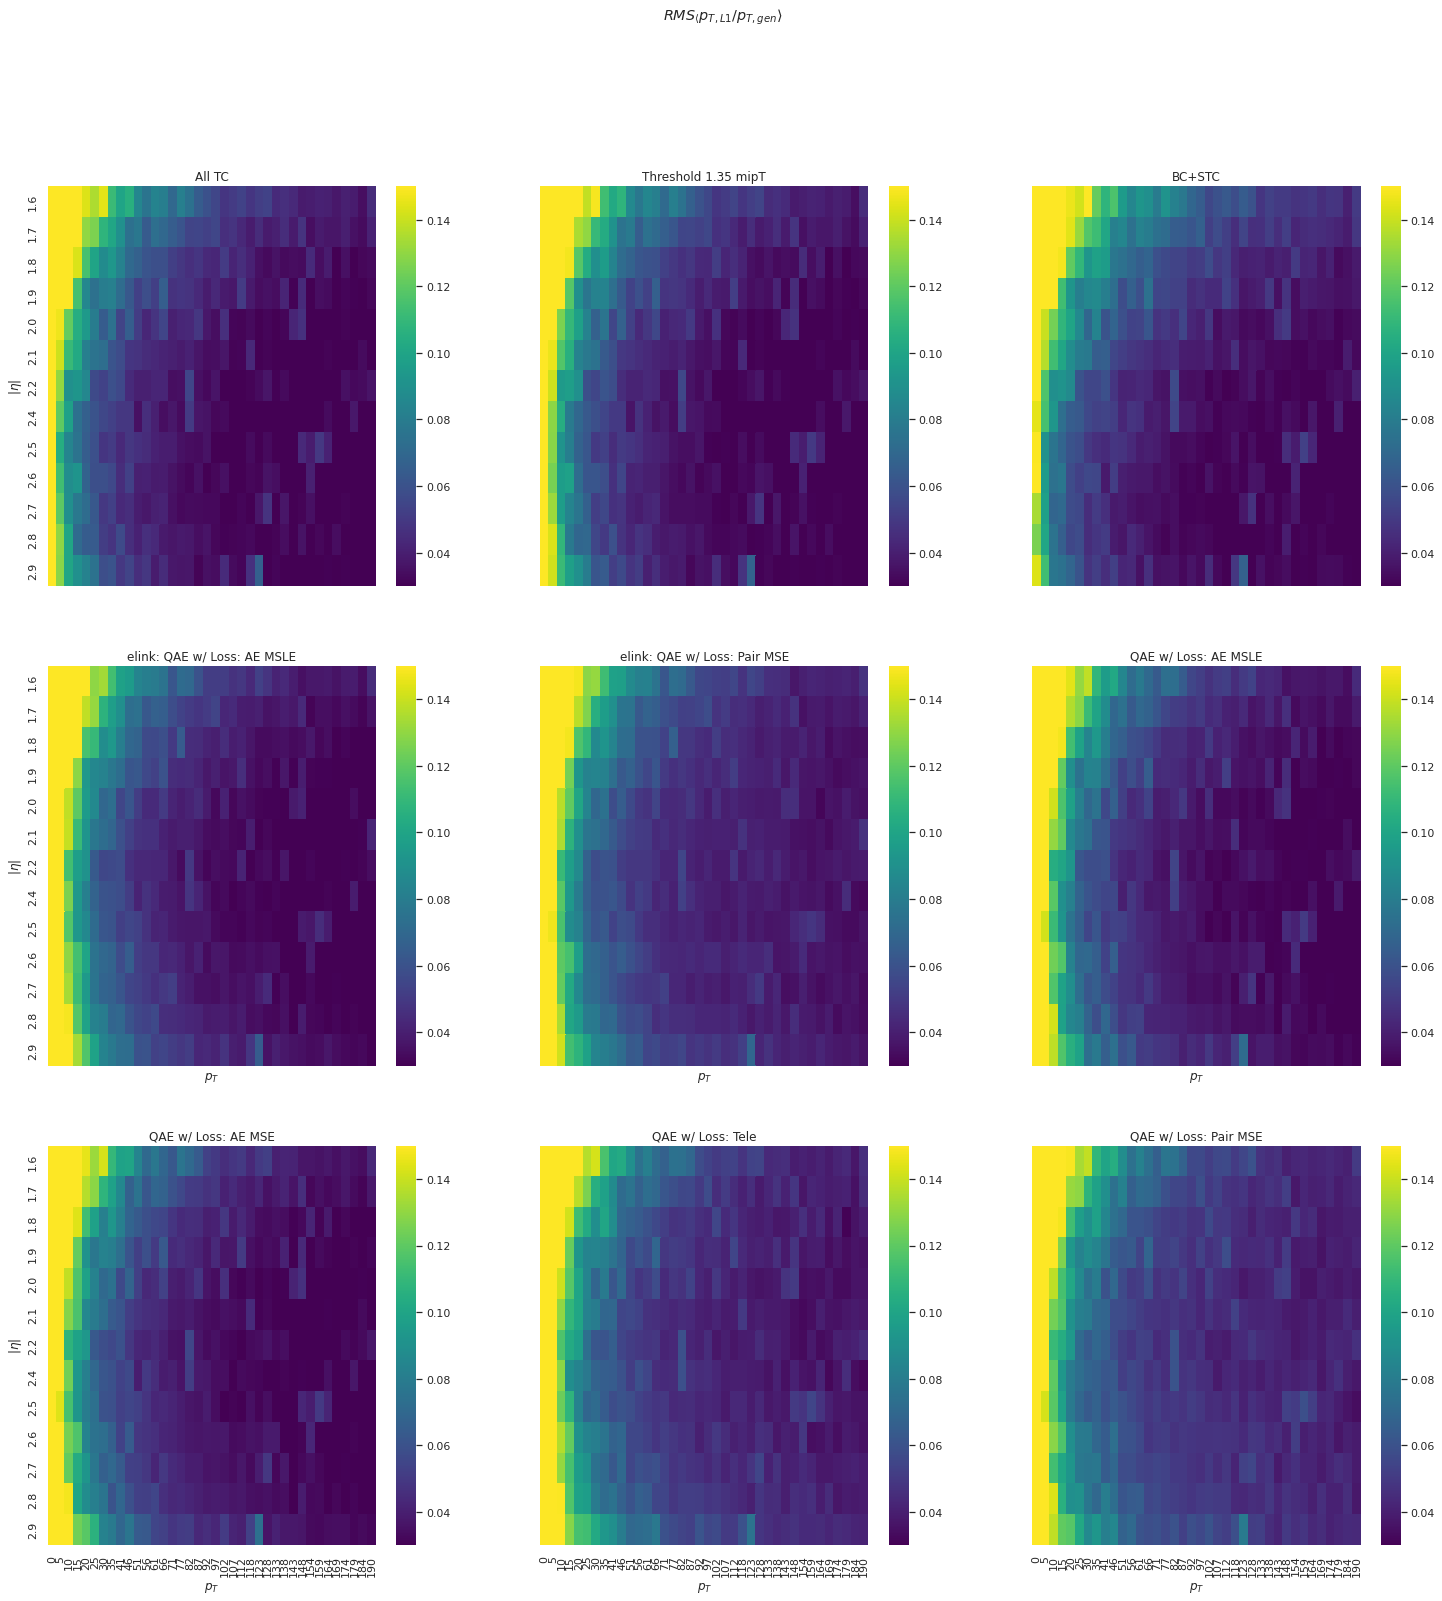

In [33]:
#RMS/Mean heatmaps

sns.set(font_scale=1.0)
fig, axes = plt.subplots(3, 3, figsize=(25, 25), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$RMS_\langle p_{T,L1}/p_{T,gen}\rangle}$')

for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//3][ix%3]
    df = both_full_rms[name]['corr_eta_over_gen_pt']/(both_means[name]['corr_eta_over_gen_pt'])
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.03, 
                vmax=0.15, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig('/home/cms.rshenoy/Plots/new_ratio_pt_rms_pt_eta.pdf')
plt.show()

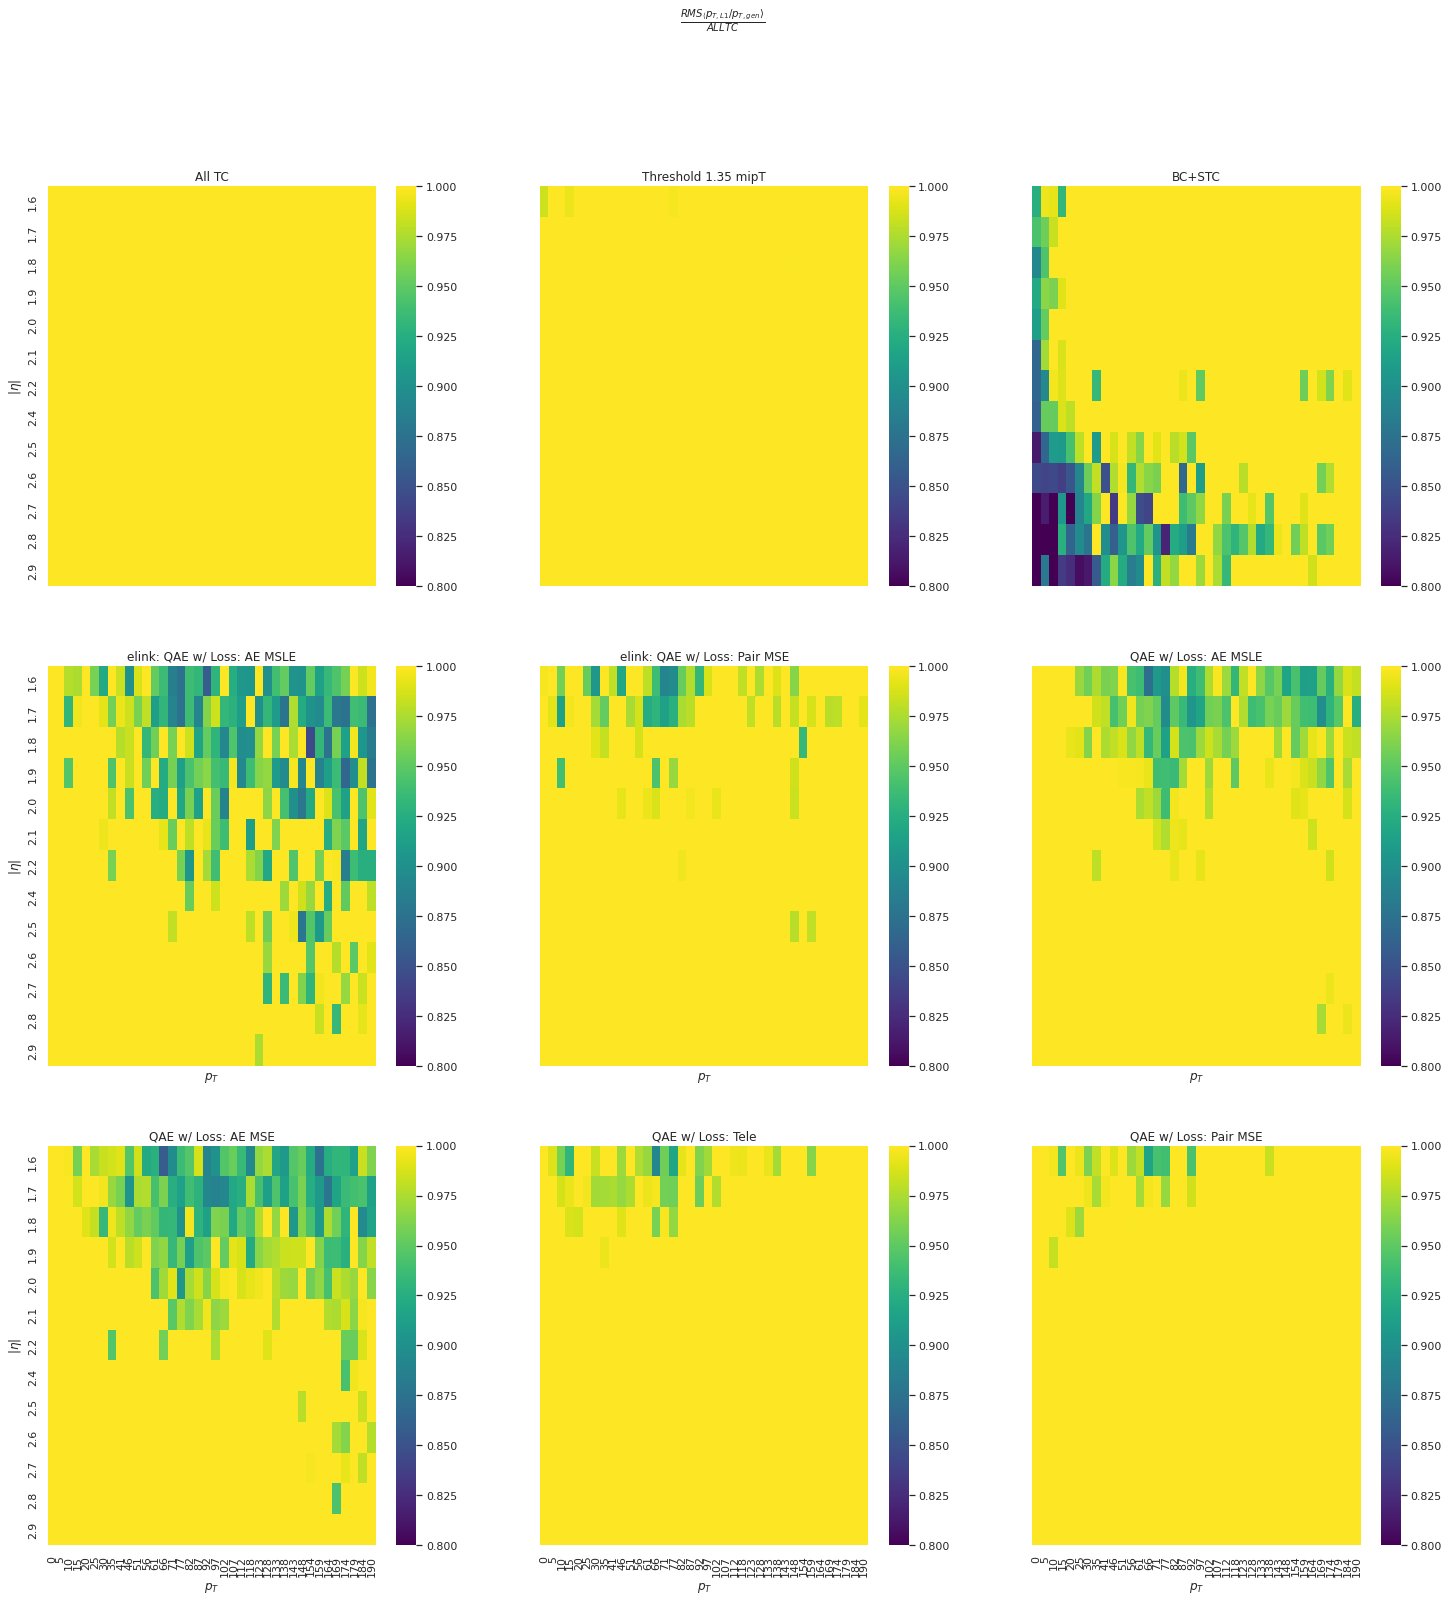

In [35]:
#Ratio RMS/Mean heatmaps
DENOM_0=(both_full_rms['Threshold0']['corr_eta_over_gen_pt'])/(both_means['Threshold0']['corr_eta_over_gen_pt'])

sns.set(font_scale=1.0)
fig, axes = plt.subplots(3, 3, figsize=(25, 25), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$\frac{RMS_\langle p_{T,L1}/p_{T,gen}\rangle}{ALL TC}$')

for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//3][ix%3]
    df = (both_full_rms[name]['corr_eta_over_gen_pt']/(both_means[name]['corr_eta_over_gen_pt']))/DENOM_0
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.8, 
                vmax=1, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig('/home/cms.rshenoy/Plots/new_ratio_pt_rms_pt_eta.pdf')
plt.show()

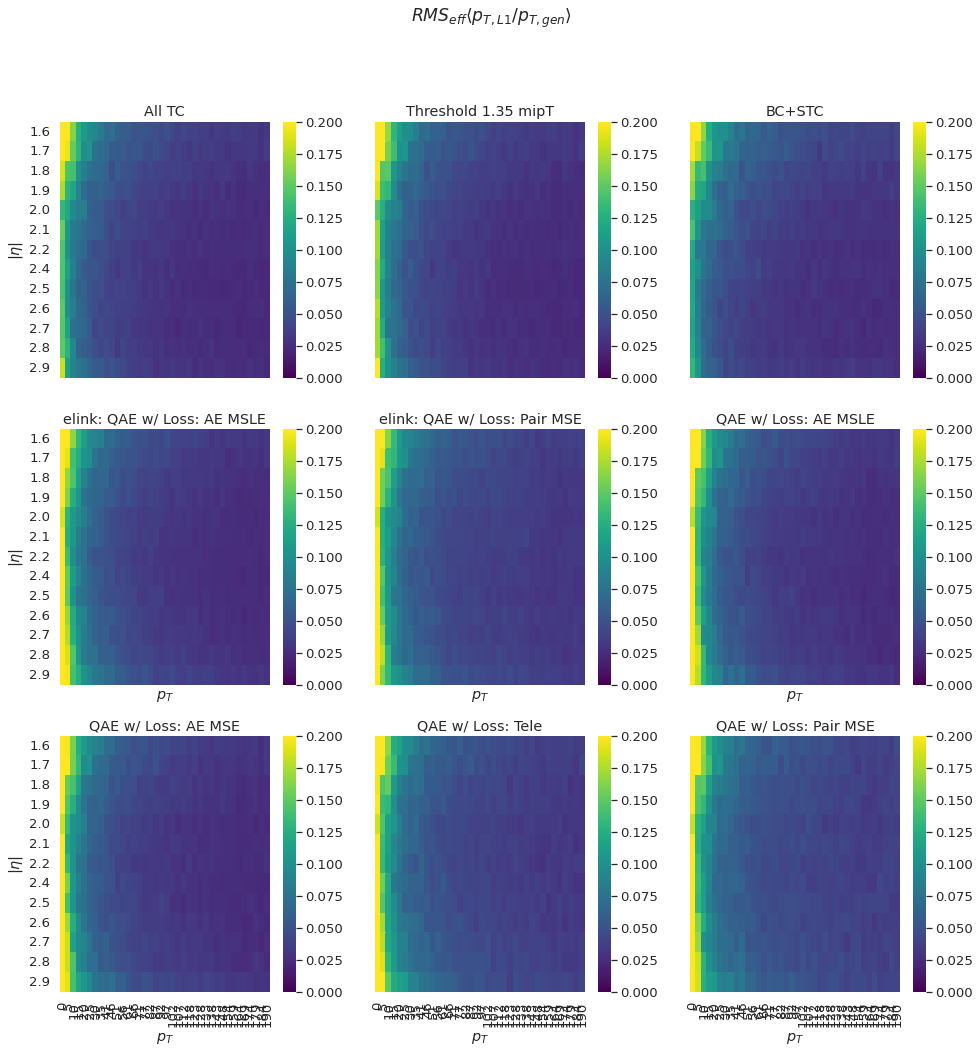

In [37]:
#RMS_eff/mean heatmaps
sns.set(font_scale=1.2)
fig, axes = plt.subplots(3, 3, figsize=(16, 16), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$RMS_{eff}\langle p_{T,L1}/p_{T,gen}\rangle$')

for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//3][ix%3]
    df = both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt']
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0, 
                vmax=0.2, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig('/home/cms.rshenoy/Plots/new_pt_rms_eff__pt_eta.pdf')
plt.show()

In [38]:
DENOM=both_eff_rms['Threshold0']['corr_eta_over_gen_pt']/both_means['Threshold0']['corr_eta_over_gen_pt']

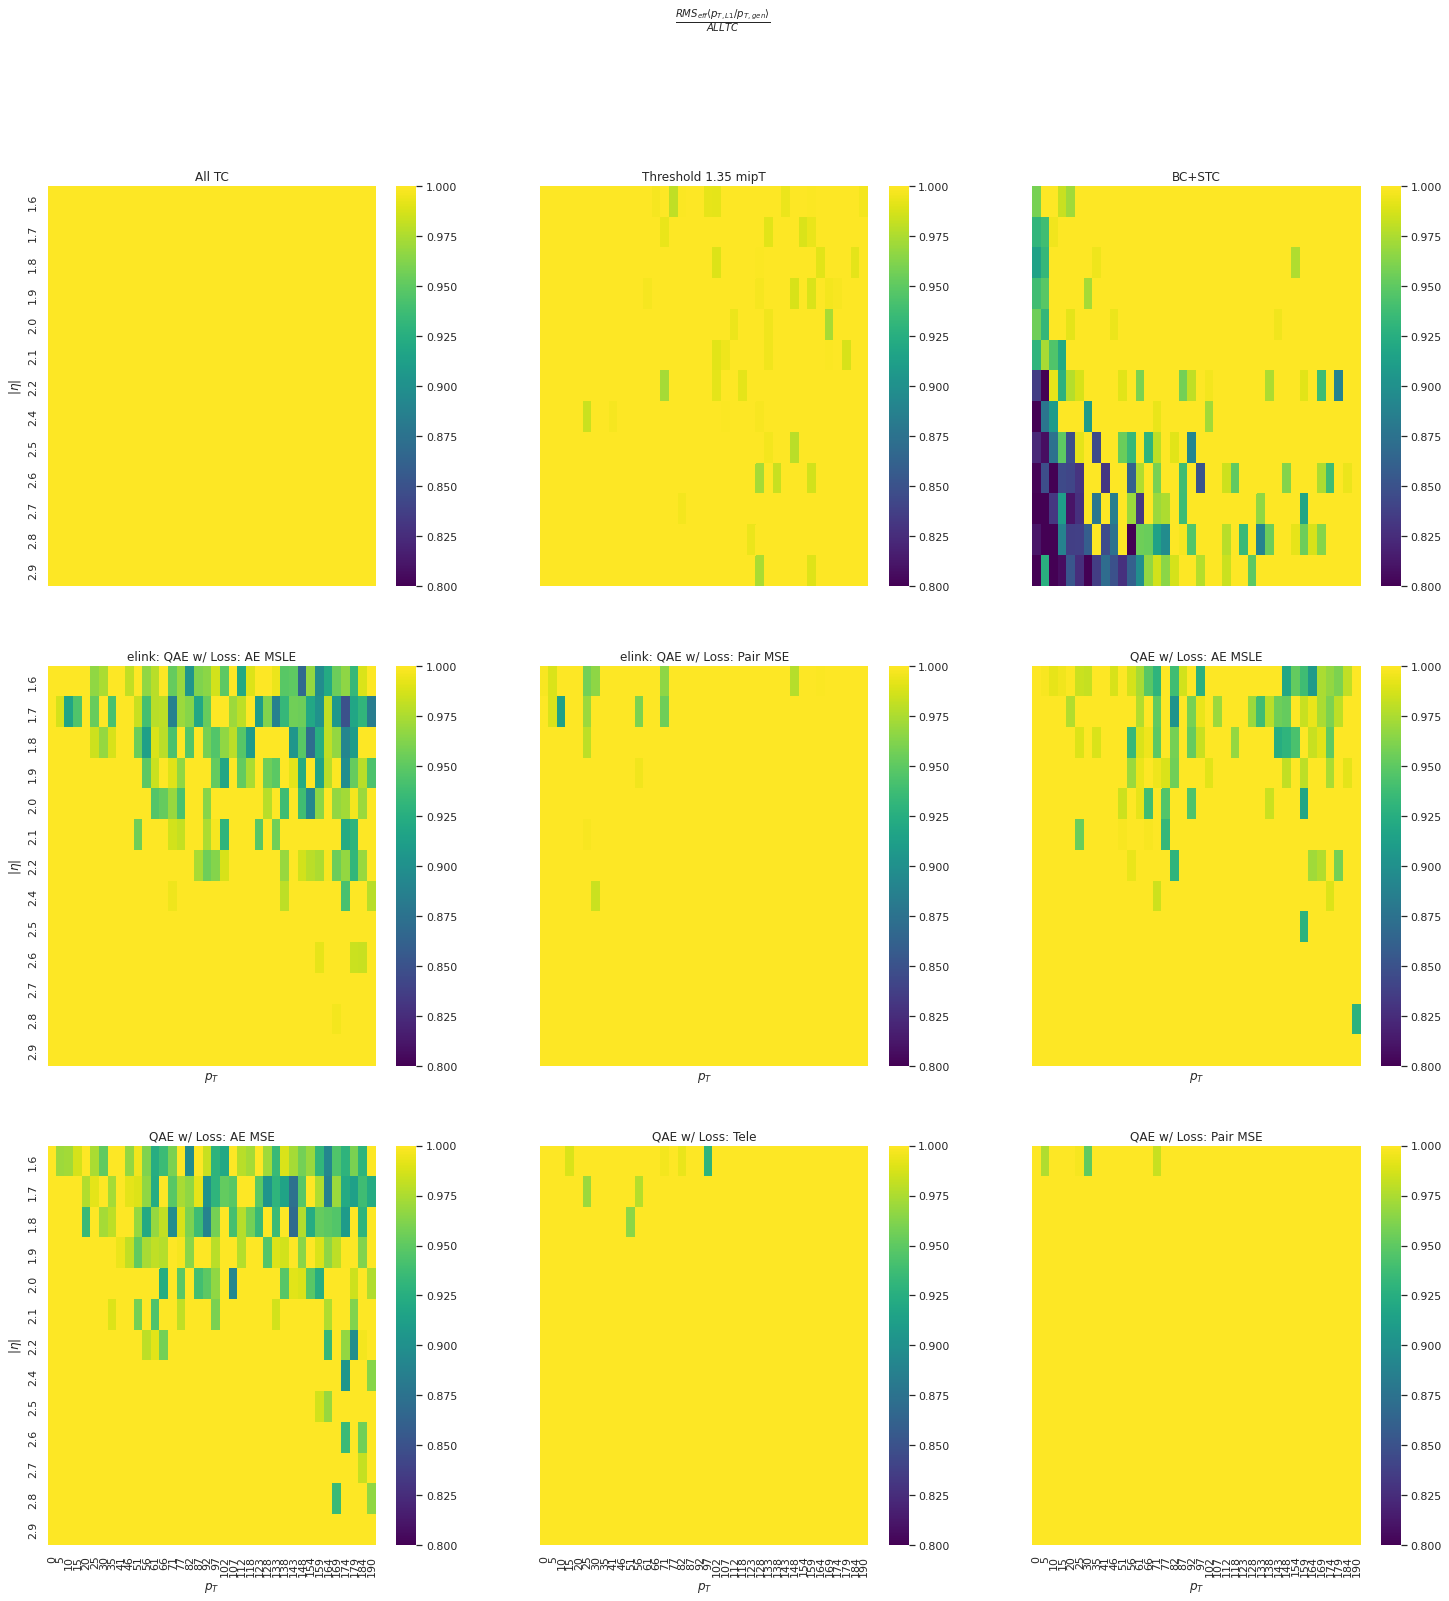

In [40]:
#Ratio RMS_eff/mean heatmaps

sns.set(font_scale=1.0)
fig, axes = plt.subplots(3, 3, figsize=(25, 25), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$\frac{RMS_{eff}\langle p_{T,L1}/p_{T,gen}\rangle}{ALL TC}$')

for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    ax = axes[ix//3][ix%3]
    df = (both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.8, 
                vmax=1, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[name])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%3 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//3 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig('/home/cms.rshenoy/Plots/new_ratio_pt_rms_eff__pt_eta.pdf')
plt.show()

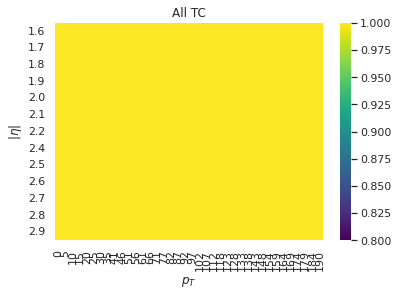

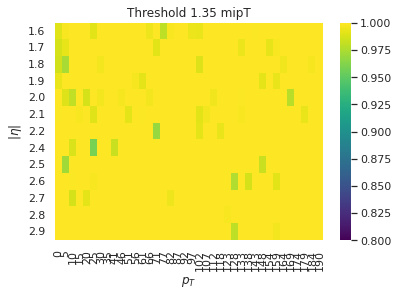

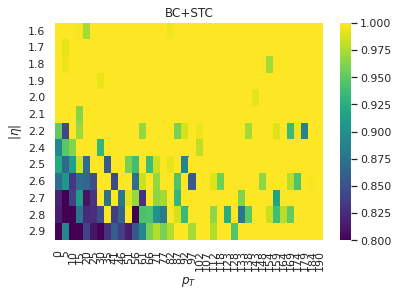

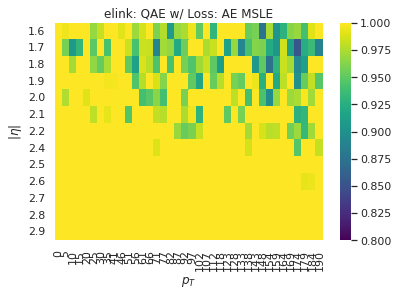

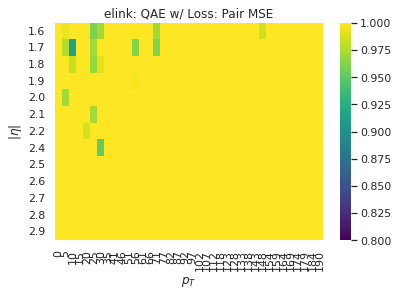

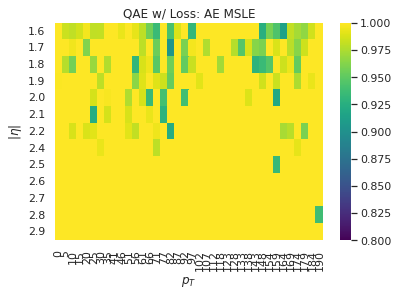

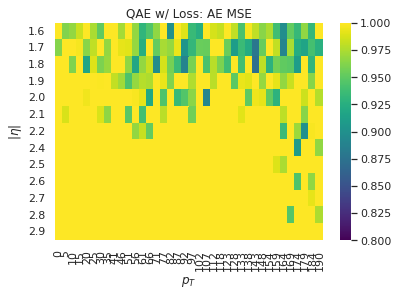

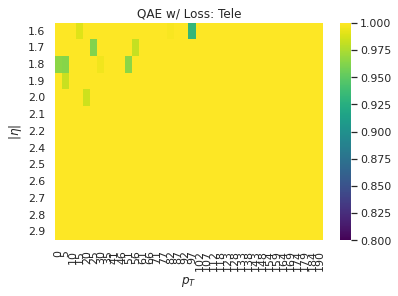

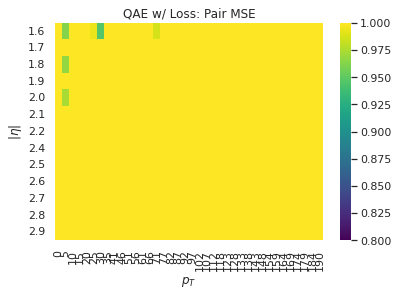

In [30]:
#Individual plots of the ones above: Ratio RMS_eff heatmaps

#sns.set(font_scale=1.0)
for ix, (name, df_algo) in enumerate(algo_cut.items()):
    
    df = (both_eff_rms[name]['corr_eta_over_gen_pt']/both_means[name]['corr_eta_over_gen_pt'])/DENOM
    df = df.reset_index().pivot(columns='genpart_binpt', index='genpart_bineta')
    sns.heatmap(df, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.8, 
                vmax=1, 
                #cbar=bool(ix%2)
               )
    plt.title(legends[name])
    plt.xlabel(r'$p_{T}$')
    plt.ylabel('$|\eta|$')
    plt.yticks(rotation=0)
    plt.savefig('/home/cms.rshenoy/Ratio/new_ratio_pt_rms_eff__pt_eta'+name+'.png',dpi=600)
    plt.show()
    df={}

